# 02 - Data Quality Checks (Phase 3)

This notebook runs row-count, null, and key-integrity checks
for the Airline Business Intelligence Database.

- Validates Phase 2 ETL results
- Guides SQL cleanup in `sql/03_dml_cleanup.sql`
- Confirms constraints in `sql/04_constraints_indexes.sql`

In [4]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from typing import Optional, Dict

# Load environment variables
load_dotenv()
db_url = os.getenv("DATABASE_URL")
if db_url is None:
    raise RuntimeError("DATABASE_URL not set in environment or .env file")

# Create engine
engine = create_engine(db_url, future=True)

def run_sql(query: str, params: Optional[Dict] = None) -> pd.DataFrame:
    """Helper to run a SQL query and return a DataFrame."""
    with engine.connect() as conn:
        result = conn.execute(text(query), params or {})
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
    return df


### Row counts per table

In [5]:
row_counts_sql = """
SELECT 'aircraft'           AS table_name, COUNT(*) AS row_count FROM airline.aircraft
UNION ALL
SELECT 'airlines',                       COUNT(*) FROM airline.airlines
UNION ALL
SELECT 'airports',                       COUNT(*) FROM airline.airports
UNION ALL
SELECT 'bookings',                       COUNT(*) FROM airline.bookings
UNION ALL
SELECT 'flight_performance',             COUNT(*) FROM airline.flight_performance
UNION ALL
SELECT 'flights',                        COUNT(*) FROM airline.flights
UNION ALL
SELECT 'loyalty_accounts',               COUNT(*) FROM airline.loyalty_accounts
UNION ALL
SELECT 'miles_transactions',             COUNT(*) FROM airline.miles_transactions
UNION ALL
SELECT 'passengers',                     COUNT(*) FROM airline.passengers
UNION ALL
SELECT 'payments',                       COUNT(*) FROM airline.payments
UNION ALL
SELECT 'routes',                         COUNT(*) FROM airline.routes
ORDER BY table_name;
"""

row_counts = run_sql(row_counts_sql)
row_counts


,table_name,row_count
0,aircraft,0
1,airlines,1108
2,airports,7697
3,bookings,40000
4,flight_performance,22595
5,flights,5000
6,loyalty_accounts,3000
7,miles_transactions,10576
8,passengers,5000
9,payments,40000


### FK / key null + orphan checks

In [6]:
fk_issues_sql = """
SELECT
  flights_missing_airline,
  flights_missing_origin_airport,
  flights_missing_destination_airport,
  bookings_missing_passenger,
  bookings_missing_flight,
  payments_missing_booking
FROM (
  SELECT
    SUM(CASE WHEN a.airline_id IS NULL THEN 1 ELSE 0 END) AS flights_missing_airline,
    SUM(CASE WHEN ao.airport_id IS NULL THEN 1 ELSE 0 END) AS flights_missing_origin_airport,
    SUM(CASE WHEN ad.airport_id IS NULL THEN 1 ELSE 0 END) AS flights_missing_destination_airport
  FROM airline.flights f
  LEFT JOIN airline.airlines a ON f.airline_id = a.airline_id
  LEFT JOIN airline.airports ao ON f.origin_airport_id = ao.airport_id
  LEFT JOIN airline.airports ad ON f.destination_airport_id = ad.airport_id
) flights_issues,
(
  SELECT
    SUM(CASE WHEN p.passenger_id IS NULL THEN 1 ELSE 0 END) AS bookings_missing_passenger,
    SUM(CASE WHEN f2.flight_id IS NULL THEN 1 ELSE 0 END) AS bookings_missing_flight
  FROM airline.bookings b
  LEFT JOIN airline.passengers p ON b.passenger_id = p.passenger_id
  LEFT JOIN airline.flights f2 ON b.flight_id = f2.flight_id
) bookings_issues,
(
  SELECT
    SUM(CASE WHEN b3.booking_id IS NULL THEN 1 ELSE 0 END) AS payments_missing_booking
  FROM airline.payments pay
  LEFT JOIN airline.bookings b3 ON pay.booking_id = b3.booking_id
) payments_issues;
"""

fk_issues = run_sql(fk_issues_sql)
fk_issues


,flights_missing_airline,flights_missing_origin_airport,flights_missing_destination_airport,bookings_missing_passenger,bookings_missing_flight,payments_missing_booking
0,0,0,0,0,0,0


### Duplicate key checks

In [7]:
duplicates_sql = """
SELECT 'airlines_iata_duplicates' AS metric,
       COUNT(*) AS count
FROM (
  SELECT iata_code
  FROM airline.airlines
  WHERE iata_code IS NOT NULL
  GROUP BY iata_code
  HAVING COUNT(*) > 1
) t
UNION ALL
SELECT 'airports_iata_duplicates',
       COUNT(*)
FROM (
  SELECT iata_code
  FROM airline.airports
  WHERE iata_code IS NOT NULL
  GROUP BY iata_code
  HAVING COUNT(*) > 1
) t2
UNION ALL
SELECT 'passenger_email_duplicates',
       COUNT(*)
FROM (
  SELECT email
  FROM airline.passengers
  WHERE email IS NOT NULL
  GROUP BY email
  HAVING COUNT(*) > 1
) t3
UNION ALL
SELECT 'loyalty_multiper_passenger',
       COUNT(*)
FROM (
  SELECT passenger_id
  FROM airline.loyalty_accounts
  GROUP BY passenger_id
  HAVING COUNT(*) > 1
) t4;
"""

dup_counts = run_sql(duplicates_sql)
dup_counts


,metric,count
0,airlines_iata_duplicates,0
1,airports_iata_duplicates,0
2,passenger_email_duplicates,0
3,loyalty_multiper_passenger,0


### "Problem Counts" summary table

In [8]:
# Melt FK issues into metric / count format
fk_problem_counts = fk_issues.melt(
    var_name="metric",
    value_name="count"
)

# Combine with duplicate counts
problem_counts = pd.concat(
    [fk_problem_counts, dup_counts],
    ignore_index=True
)

problem_counts


,metric,count
0,flights_missing_airline,0
1,flights_missing_origin_airport,0
2,flights_missing_destination_airport,0
3,bookings_missing_passenger,0
4,bookings_missing_flight,0
5,payments_missing_booking,0
6,airlines_iata_duplicates,0
7,airports_iata_duplicates,0
8,passenger_email_duplicates,0
9,loyalty_multiper_passenger,0


### Simple quality-check chart

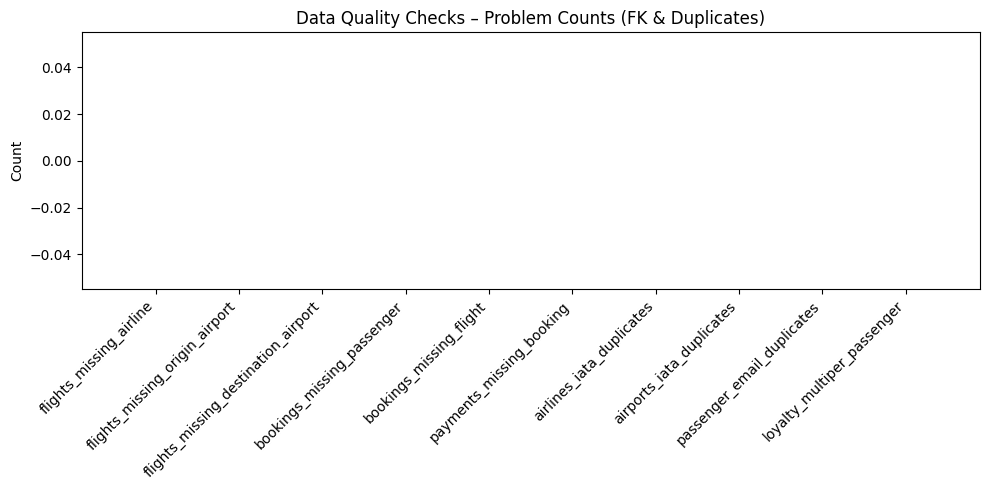

In [9]:
import matplotlib.pyplot as plt

# Filter to only metrics with non-null counts (keep zeros)
plot_df = problem_counts.copy()

plt.figure(figsize=(10, 5))
plt.bar(plot_df["metric"], plot_df["count"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Data Quality Checks – Problem Counts (FK & Duplicates)")
plt.tight_layout()

# Make sure docs/ exists
os.makedirs("docs", exist_ok=True)

plt.savefig("docs/pipeline_quality_checks.png", dpi=200)
plt.show()
